In [45]:
import torch
import torch.nn as nn 
import torch.optim as optim 

from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
import torchvision.utils as vutils  

import matplotlib.pyplot as plt 

In [47]:
# Hyperparameters  
batch_size = 128
image_size = 28 
z_dim = 100 
num_epochs = 20 
lr = 0.0002 
beta1 = 0.5 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [49]:
# Load Data - Transforms : 
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.ToTensor(), 
    transforms.Normalize([0.5],[0.5])
])

In [51]:
# Data Loading..  
datasets = datasets.MNIST(root='./data', download=True, transform=transform) 
dataloader = DataLoader(datasets,batch_size=batch_size, shuffle=True)

In [61]:
# Generator  
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, 256, 7, 1, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 1, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.net(x)


In [63]:
# Discriminator 

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),
            nn.Linear(256 * 7 * 7, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)


In [65]:
netG = Generator(z_dim).to(device)
netD = Discriminator().to(device)  

criterion = nn.BCELoss() 
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


[1/20] Loss_D: 0.0001, Loss_G: 9.9085


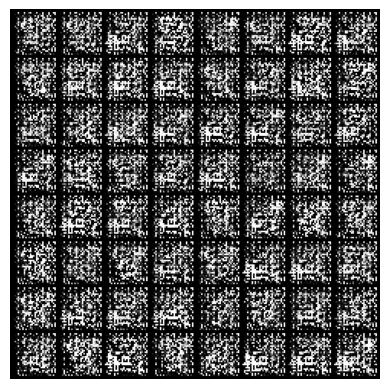

[2/20] Loss_D: 0.0001, Loss_G: 11.0084


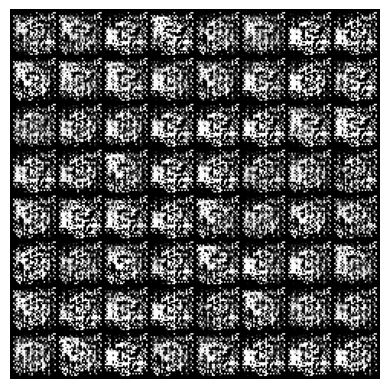

In [ ]:
# Models and Optimizers 

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(dataloader):
        real_images = real_images.to(device)
        b_size = real_images.size(0)
        real_labels = torch.ones(b_size, device=device) 
        fake_labels = torch.zeros(b_size, device=device) 
        # Train Discriminator 
        netD.zero_grad() 
        output_real = netD(real_images).view(-1)
        lossD_real = criterion(output_real, real_labels)  

        noise = torch.randn(b_size, z_dim, 1, 1, device=device) 
        fake_images = netG(noise) 
        output_fake = netD(fake_images.detach()).view(-1)
        lossD_fake = criterion(output_fake, fake_labels) 

        lossD = lossD_real + lossD_fake 
        lossD.backward() 
        optimizerD.step() 

        # Train Generator 
        netG.zero_grad() 
        output = netD(fake_images).view(-1) 
        lossG = criterion(output, real_labels)  # trick D
        lossG.backward()
        optimizerG.step() 
    print(f"[{epoch+1}/{num_epochs}] Loss_D: {lossD.item():.4f}, Loss_G: {lossG.item():.4f}") 

    with torch.no_grad(): 
        fake = netG(fixed_noise).detach().cpu() 
        grid = vutils.make_grid(fake, padding=2, normalize=True)
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis("off")
        plt.show()
        
